In [1]:
# lightweight_mmm uses jax.numpy for the data
import jax.numpy as jnp
import numpyro
import numpy as np
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

In [2]:
import pandas as pd
df = pd.read_csv("MMM data FR.csv")
df.head()

,start,transactions,revenue TTC,google ads hors brand cost,google ads hors brand impr,google ads brand cost,google ads brand impr,meta ads hors brand cost,meta ads hors brand impr,meta ads brand cost,meta ads brand impr,black Friday,french days,soldes
0,19/10/2020,883,295742.87,29882.88,3824241,820.29,26560,422.40,28121,958.81,199334,0,0,0
1,26/10/2020,1364,466938.27,30766.58,3906382,1058.84,44245,416.08,33503,939.67,175420,0,0,0
2,2/11/2020,1665,590958.27,40705.83,4356721,1193.91,49526,2064.86,279639,911.06,156196,0,0,0
3,9/11/2020,1547,543221.96,36166.60,7469183,525.63,21938,3497.41,513778,908.53,137958,0,0,0
4,16/11/2020,1543,508274.25,31668.56,8097667,270.39,25006,4572.73,557254,981.38,127005,1,0,0


In [3]:
mdsp_cols=[col for col in df.columns if 'cost' in col ]

mdimpr_cols=[col for col in df.columns if 'impr' in col ]

In [4]:
SEED= 105
data_size = len(df)
n_media_channels = len(mdsp_cols)
media_data = df[mdsp_cols].to_numpy()
target = df['transactions'].to_numpy()
costs = df[mdsp_cols].sum().to_numpy()
extra_features=df[['black Friday','french days','soldes']].to_numpy()


In [5]:
test_data_period_size = 13
split_point = data_size - test_data_period_size
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
target_train = target[:split_point]
extra_features_train=extra_features[:split_point]
extra_features_test=extra_features[split_point:]
media_names=["google ads acquisition", "google ads brand", "facebook ads acquisition","facebook ads RMK"]

In [6]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train=extra_features_scaler.fit_transform(extra_features_train)

target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
correlations, variances, spend_fractions, variance_inflation_factors = preprocessing.check_data_quality(
    media_data=media_scaler.transform(media_data),
    target_data=target_scaler.transform(target),
    cost_data=costs,
    extra_features_data=extra_features_scaler.transform(extra_features))

In [8]:
correlations[0].style.background_gradient(cmap='RdBu', vmin=-1, vmax=1)


,feature_0,feature_1,feature_2,feature_3,extra_feature_0,extra_feature_1,extra_feature_2,target
feature_0,1.000000,0.533658,0.128694,0.389988,0.657264,-0.053384,-0.124622,0.790555
feature_1,0.533658,1.000000,0.484072,0.155901,0.420701,-0.024575,-0.000891,0.661445
feature_2,0.128694,0.484072,1.000000,0.167616,0.026019,-0.084559,0.106087,0.535515
feature_3,0.389988,0.155901,0.167616,1.000000,0.315767,0.086555,0.071370,0.287692
extra_feature_0,0.657264,0.420701,0.026019,0.315767,1.000001,-0.048131,-0.129896,0.615002
extra_feature_1,-0.053384,-0.024575,-0.084559,0.086555,-0.048131,1.000001,-0.072940,-0.057380
extra_feature_2,-0.124622,-0.000891,0.106087,0.071370,-0.129896,-0.072940,0.999999,-0.035906
target,0.790555,0.661445,0.535515,0.287692,0.615002,-0.057380,-0.035906,1.000000


In [9]:
def highlight_variances(x: float, 
                        low_variance_threshold: float=1.0e-3, 
                        high_variance_threshold: float=3.0) -> str:

    if x < low_variance_threshold or x > high_variance_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'gray'
    style = f'font-weight: {weight}; color: {color}'
    return style

variances.style.format(precision=4).applymap(highlight_variances)

,geo_0
feature_0,0.2137
feature_1,1.4958
feature_2,0.7123
feature_3,0.0852
extra_feature_0,9.7564
extra_feature_1,30.9417
extra_feature_2,6.6378


In [10]:
def highlight_high_vif_values(x: float,
                              high_vif_threshold: float=7.0) -> str:
    if x > high_vif_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'gray'
    style = f'font-weight: {weight}; color: {color}'
    return style

variance_inflation_factors.style.format(precision=4).applymap(highlight_high_vif_values)

,geo_0
feature_0,2.2780
feature_1,1.9864
feature_2,1.4665
feature_3,1.2999
extra_feature_0,1.8717
extra_feature_1,1.0433
extra_feature_2,1.0632


In [11]:
mmm = lightweight_mmm.LightweightMMM(model_name="adstock")

In [12]:
#parameters used for the configuration of the sampling algorithm
number_warmup=2000
number_samples=2000


In [ ]:
#Adstock customs
c1 = np.array([2] * len(mdsp_cols))
c0 = np.array([0.5] * len(mdsp_cols))
c1[0]=1
c0[1]=2
extra_loc=np.array([.01] * 3)
extra_scale=np.array([.02] * 3)
extra_loc[1]=0.01
extra_scale[1]=0.1


In [13]:
mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    media_names= media_names,
    degrees_seasonality=3,
    
    custom_priors={"coef_extra_features": {"loc":extra_loc, "scale":extra_scale}, 
                   "intercept" : numpyro.distributions.HalfNormal(scale=1.),
                   "coef_trend":numpyro.distributions.Normal(loc=.1, scale=1.),
                   "expo_trend":numpyro.distributions.Uniform(low=0.5, high=1.8),
                   "sigma":numpyro.distributions.Gamma(concentration=1., rate=1.),
                   "exponent":numpyro.distributions.Beta(concentration1=9., concentration0=1.),
                   "lag_weight":{'concentration1': c1, 'concentration0': c0}},
    seed=SEED)

c:\Users\Arij\Desktop\certideal\lightweight_mmm_new\lightweight_mmm\lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 4000/4000 [01:07<00:00, 59.52it/s, 127 steps of size 2.70e-02. acc. prob=0.80] 


In [14]:
mmm.print_summary()   



                            mean       std    median      5.0%     95.0%     n_eff     r_hat
coef_extra_features[0]      0.02      0.01      0.02      0.01      0.03    826.52      1.00
coef_extra_features[1]      0.00      0.00      0.00     -0.00      0.01    386.94      1.01
coef_extra_features[2]      0.00      0.01      0.00     -0.01      0.01    931.98      1.00
         coef_media[0]      0.70      0.07      0.70      0.58      0.81    439.30      1.00
         coef_media[1]      0.01      0.01      0.01      0.00      0.03   1670.00      1.00
         coef_media[2]      0.47      0.17      0.45      0.23      0.73    778.68      1.00
         coef_media[3]      0.06      0.05      0.05      0.00      0.13   1265.89      1.00
         coef_trend[0]     -0.01      0.01     -0.01     -0.03      0.00    511.81      1.00
            expo_trend      0.67      0.14      0.64      0.50      0.88    145.91      1.01
           exponent[0]      0.95      0.04      0.96      0.89      1

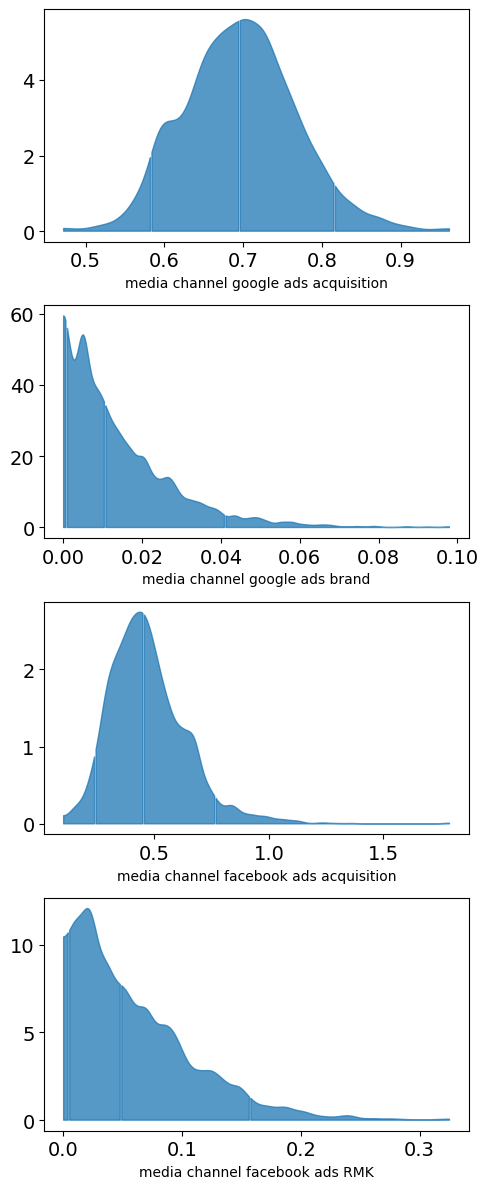

In [15]:
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=media_names )


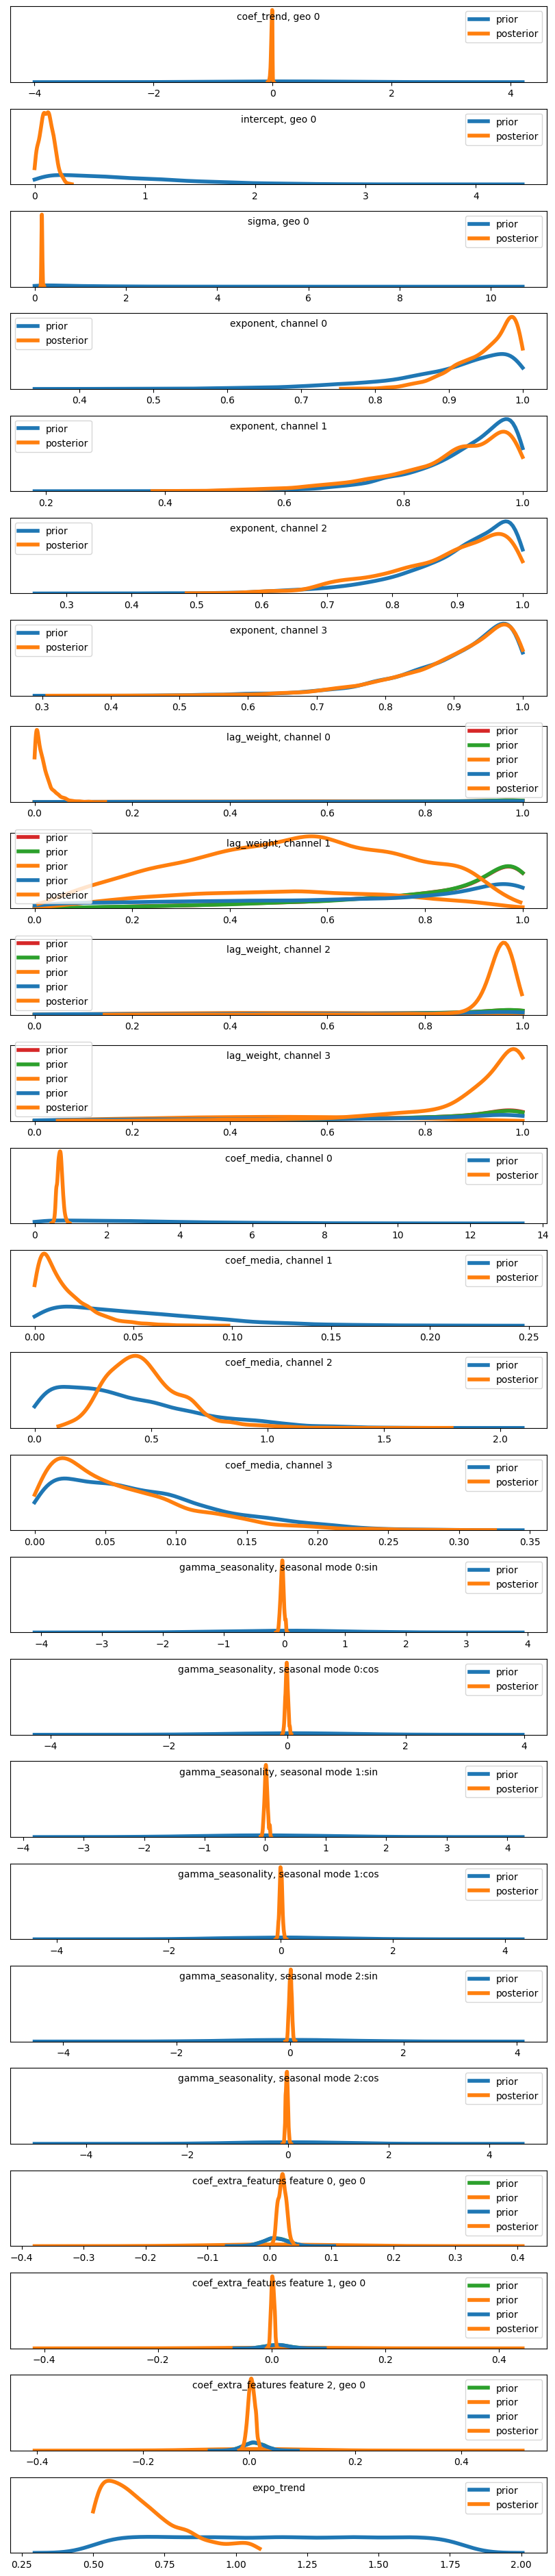

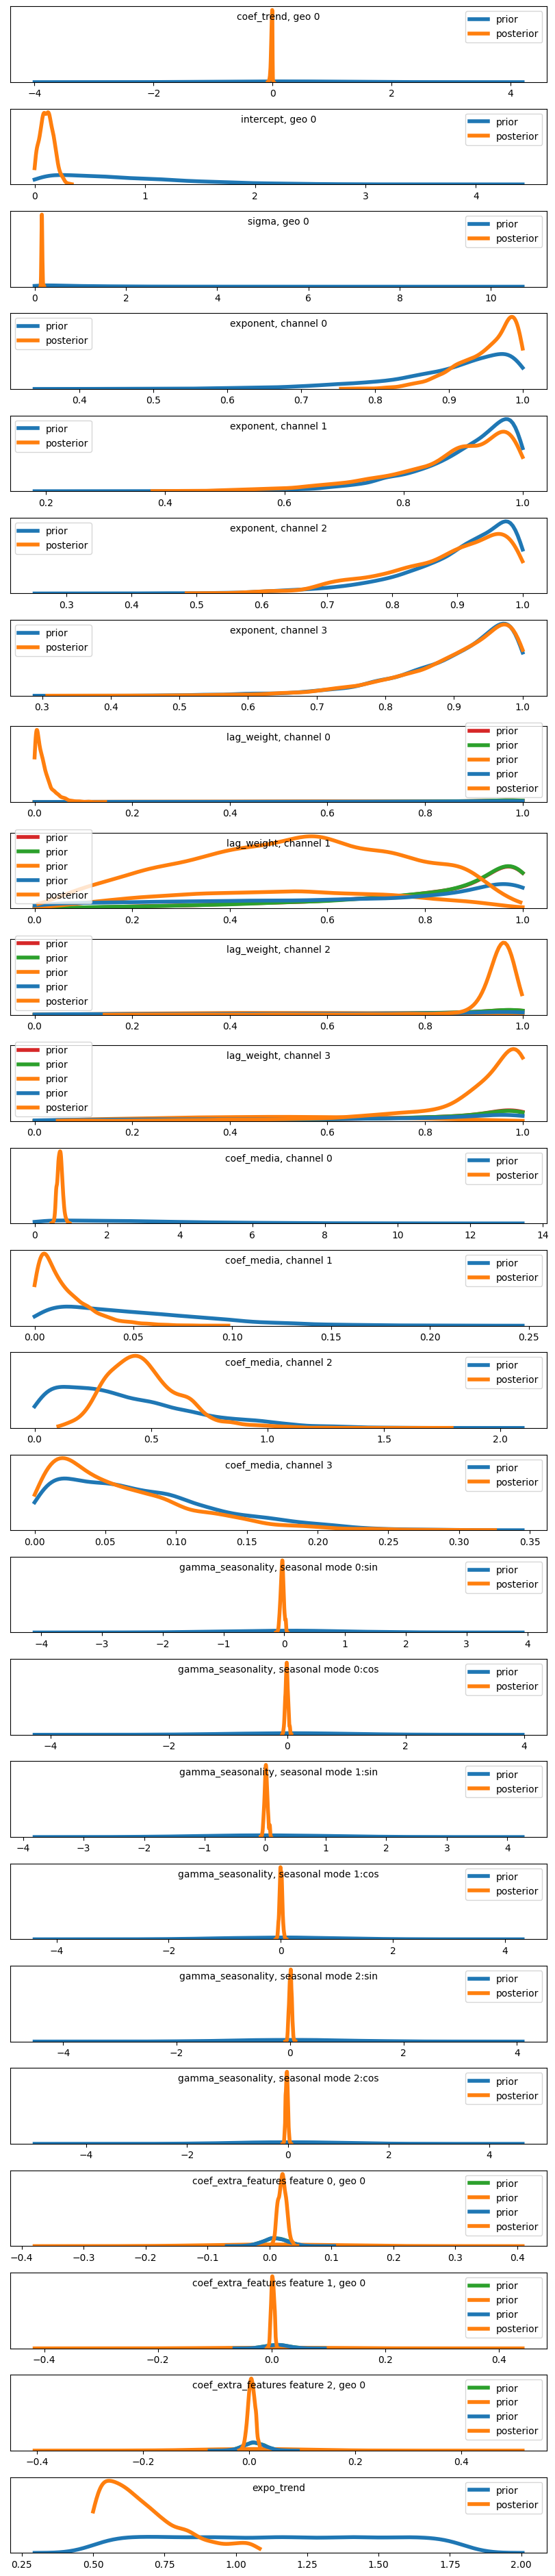

In [16]:
plot.plot_prior_and_posterior(media_mix_model=mmm)


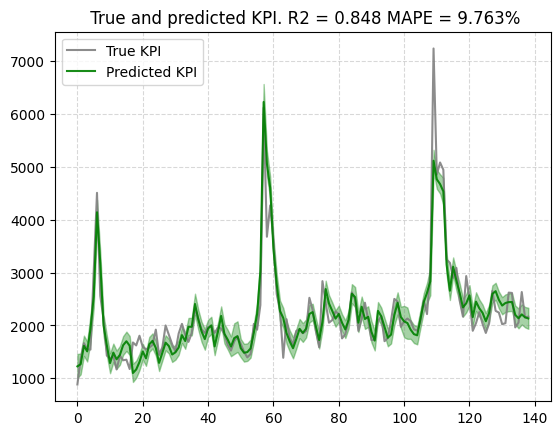

In [17]:
plot.plot_model_fit(mmm, target_scaler=target_scaler )


In [18]:
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test), extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=SEED)
new_predictions.shape

(4000, 13)

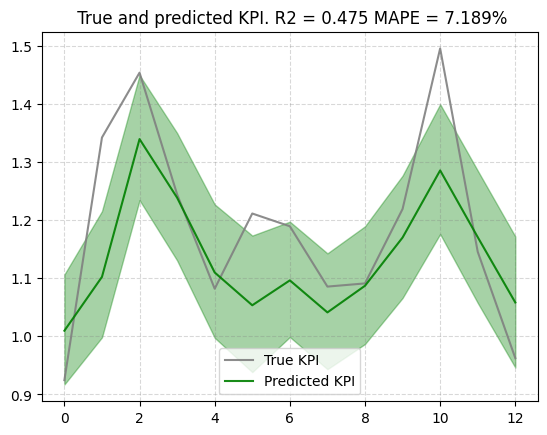

In [19]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:]))

In [20]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)


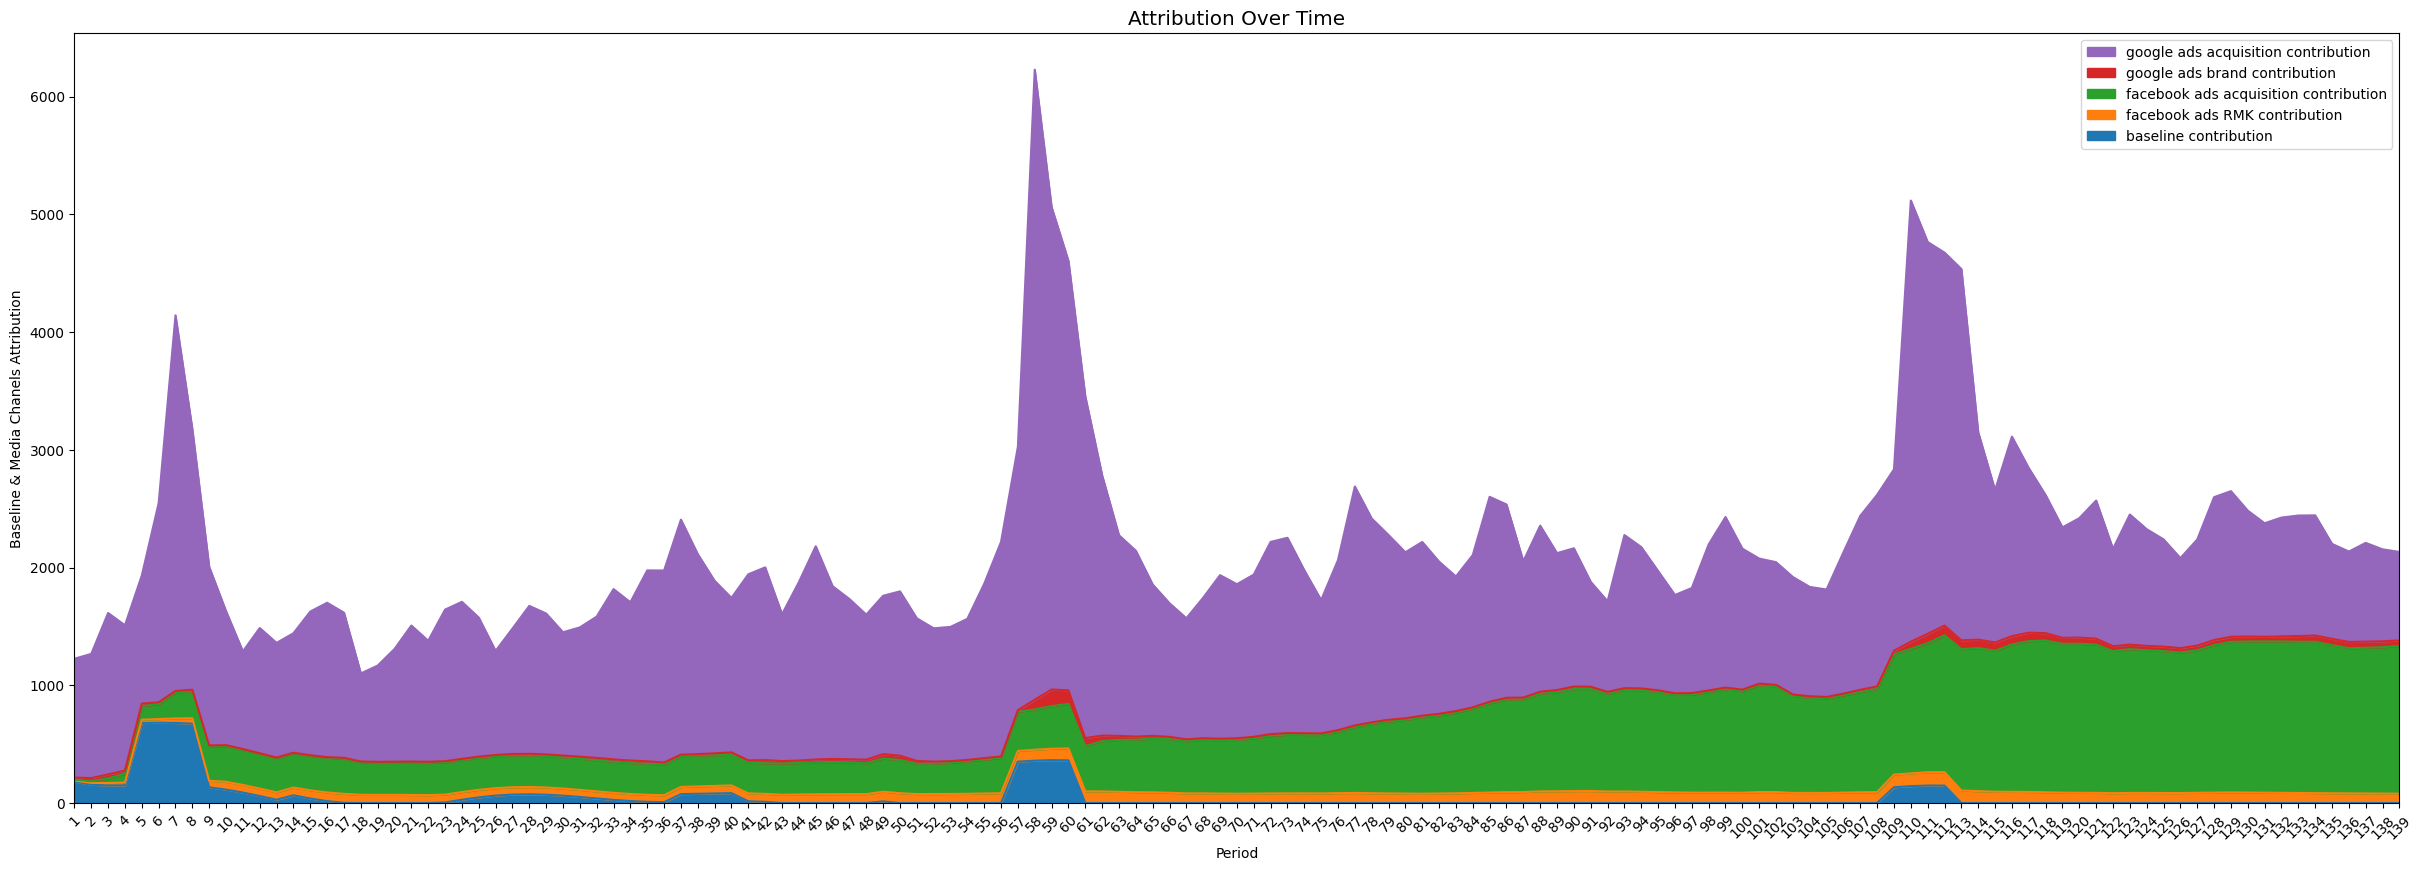

In [21]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10))

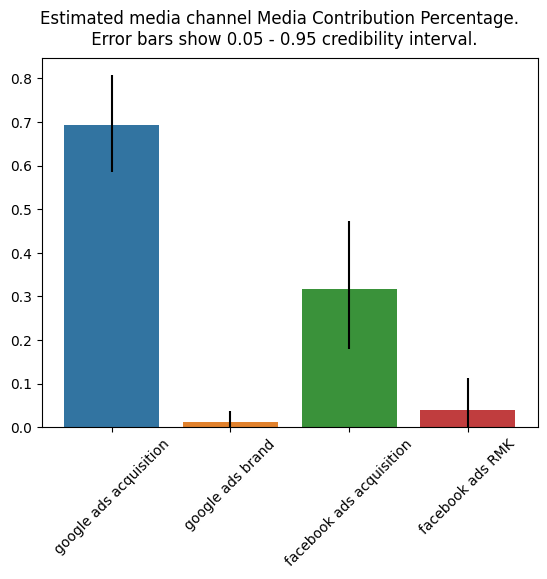

In [22]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage", channel_names=media_names)


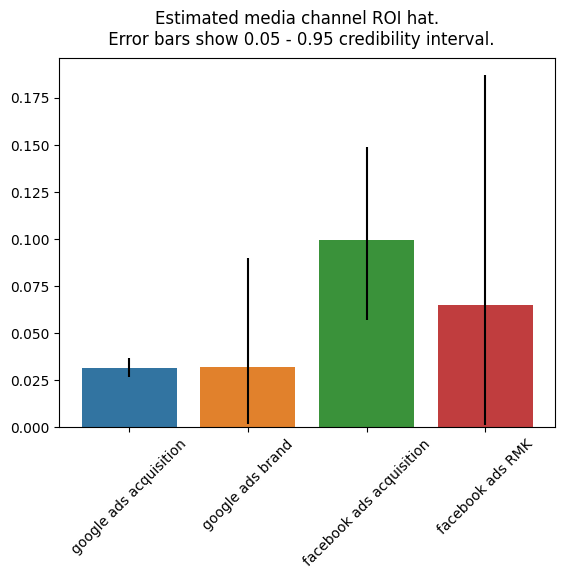

In [23]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names=media_names)


In [24]:
prices = jnp.ones(mmm.n_media_channels)


In [32]:
n_time_periods = 20
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods

In [34]:
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    budget=budget,
    prices=prices,
    
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -49719.449590898905
            Iterations: 39
            Function evaluations: 351
            Gradient evaluations: 39


In [35]:
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([871296.4  ,  13660.407, 137411.27 ,  29185.328], dtype=float32)

In [36]:
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([898670.06 ,  15225.26 , 113542.39 ,  24115.723], dtype=float32)

In [37]:
budget, optimal_buget_allocation.sum()

(Array(1051553.4, dtype=float32), Array(1051553.4, dtype=float32))

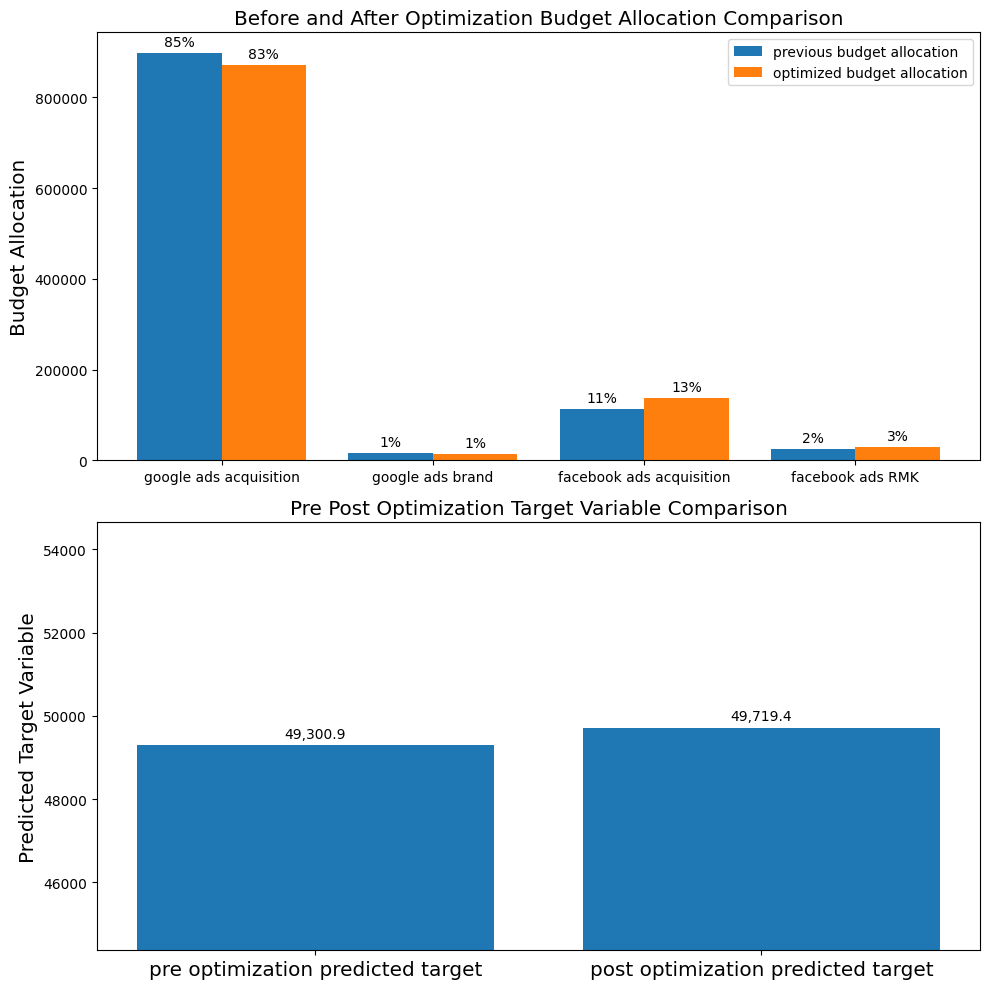

In [38]:
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(10,10))